Install packages

In [0]:
!pip install torch

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import csv
import re
from google.colab import files
import numpy as np
from random import shuffle, choice, seed
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt                                                 

In [3]:
uploaded = files.upload()

Saving offenseval-training-v1.tsv to offenseval-training-v1.tsv


In [0]:
torch.manual_seed(3521536)
seed(35215369)
np.random.seed(3521536)

In [0]:
class FeedForwardNet(nn.Module):

    def __init__(self, input_size, output_size, hidden_layer1, hidden_layer2, hidden_layer3):
        super(FeedForwardNet, self).__init__()
        
        self.layer1 = nn.Linear(input_size, hidden_layer1)
        self.layer1.weight.data.normal_(0,0.1)
        self.layer2 = nn.Linear(hidden_layer1, hidden_layer2)
        self.layer2.weight.data.normal_(0,0.1)
        self.layer3 = nn.Linear(hidden_layer2, hidden_layer3)
        self.layer3.weight.data.normal_(0,0.1)
        self.layer4 = nn.Linear(hidden_layer3, output_size)
        self.layer4.weight.data.normal_(0,0.1)

        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.relu(x)
        x = self.layer4(x)
        return F.log_softmax(x, dim=0)
      
    def l1_regularizer(self):
        l1 = self.layer1.weight.sum() + self.layer1.bias.sum()
        l2 = self.layer2.weight.sum() + self.layer2.bias.sum()
        l3 = self.layer3.weight.sum() + self.layer3.bias.sum()
        l4 = self.layer4.weight.sum() + self.layer4.bias.sum()
        return l1+l2+l3+l4
        
def train_model(model, inputs, targets, optimizer, num_epochs, batch_size):
    for epoch in range(num_epochs):
        print("EPOCH {0}".format(epoch))
        for i in range(0, len(inputs), batch_size):
            optimizer.zero_grad()
            
            out = model(inputs[i:i+batch_size])
            loss = F.nll_loss(out, targets[i:i+batch_size])
        
            loss.backward()
            optimizer.step()


def eval_model(model, inputs, targets):
    with torch.no_grad():
        out = model(inputs)
        pred = out.argmax(dim=1)
    
    acc = accuracy_score(targets, pred)
    f1 = f1_score(targets, pred, average = 'macro') 
    print("Accuracy:")
    print(acc)
    print("F1:")
    print(f1)
    cm = confusion_matrix(targets, pred)
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['IND','GRP','OTH']
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    plt.title('Target Classification Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for i in range(3):
       for j in range(3):
           plt.text(j, i, str(cm[i][j]))
    plt.show()



In [0]:
def case_normalization(msg):
    return msg.strip().lower()

def remove_delimiters(msg):
    filter_func = None
    return filter(filter_func, re.split('[ ,.!]', msg))

def pre_process_msg(msg):
    return remove_delimiters(case_normalization(msg))

def load_training_data(path):
    IND = [] 
    GRP = [] 
    OTH = [] 
    with open(path, 'r') as tsv:
        in_file = csv.reader(tsv, delimiter='\t')
        next(in_file)
        for row in in_file:
            label = row[4]
            
            if label == 'IND':
                IND.append(row[1])
            elif label == 'GRP':
                GRP.append(row[1])
            elif label == 'OTH':
                OTH.append(row[1])

    print('Training data balance - IND: {0}, GRP: {1}, OTH: {2}'.format(len(IND), len(GRP), len(OTH))) 
    return IND, GRP, OTH
  
def load_test_data(path):
    inputs = []
    IDs = []
    with open(path, 'r') as tsv:
        in_file = csv.reader(tsv, delimiter='\t')
        next(in_file)
        for row in in_file:
            IDs.append(row[0])
            inputs.append(row[1])

    return IDs, inputs  

def preprocess(ind, grp, oth):
    labels = [0] * len(ind) + [1] * len(grp) + [2] * len(oth)
    data = list(zip(ind + grp + oth, labels))
    shuffle(data)
    text, labels = map(list, zip(*data))
    text = [' '.join(list(pre_process_msg(t))) for t in text]

    return text, labels

# text as list of sentences ['i am a cat']
def vectorize_train(text, vector_size=10, window_size=2, epochs=5):
    docs = [TaggedDocument(t, [i]) for i, t in enumerate(text)]
    model = Doc2Vec(docs, min_count=1, vector_size=vector_size, window=window_size, epochs=epochs)
    model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    return model, [model.infer_vector(t.split()) for t in text]

def vectorize_eval(model, text):
    return [model.infer_vector(t.split()) for t in text]



Training data balance - IND: 2407, GRP: 1074, OTH: 395
EPOCH 0
EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9
Accuracy:
0.5891472868217055
F1:
0.36541586846190866


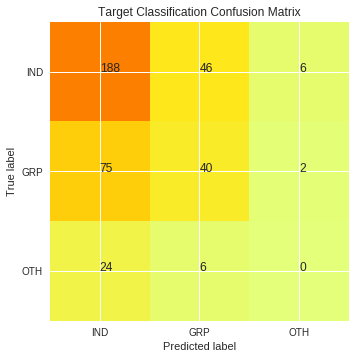

In [20]:

if __name__ == '__main__':
    sentence_vector_size = 500
    data = load_training_data('offenseval-training-v1.tsv')
    text, targets = preprocess(*data)
    word_model, inputs = vectorize_train(text, sentence_vector_size)
    break_point = len(inputs) // 10
    net = FeedForwardNet(sentence_vector_size, 3, 200, 100, 50)
    train_model(net, torch.Tensor(inputs[break_point:]), torch.Tensor(targets[break_point:]).long(), 
                          optim.Adam(net.parameters(), lr=0.01),
                          10, 19)

    test_ids, test_text = load_test_data('test_set_taskc.tsv')
    
    test_inputs = vectorize_eval(word_model, test_text)
    test_outputs = [net(torch.Tensor(v)) for v in test_inputs]

    with open('output.csv', 'w') as tsv:
        out_file = csv.writer(tsv, delimiter=',')
        for i in range(len(test_outputs)):
            index = test_outputs[i].argmax(dim=0)
            if index == 0:
                out = 'IND'
            elif index == 1:
                out = 'GRP'
            elif index == 2:
                out = 'OTH'

            out_file.writerow([test_ids[i], out])

    eval_model(net, torch.Tensor(inputs[:break_point]), torch.Tensor(targets[:break_point]).long())


